<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/analysis_scripts/fmri_dementia_lstm_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score

!pip install -qU focal_loss_torch
from focal_loss.focal_loss import FocalLoss

!pip install -qU tsai
from tsai.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.3 MB/s eta 0:00:00


In [ ]:
my_setup()

os              : Linux-5.10.147+-x86_64-with-glibc2.29
python          : 3.8.10
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu116
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


# Import data

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia"

labels = pd.read_csv(os.path.join(data_path, 'labels_new.csv'))

# Create datasets

In [ ]:
labels_train_val, labels_test = train_test_split(labels, test_size = 0.1,
                                            shuffle = True, random_state = 42,
                                            stratify = labels['label'])

labels_train_val = labels_train_val.reset_index()
labels_test = labels_test.reset_index()

# labels_train_val.to_csv(os.path.join(data_path, 'labels_train_val.csv'), header = True)
# labels_test.to_csv(os.path.join(data_path, 'labels_test.csv'), header = True)

In [ ]:
def get_datasets(data_csv):

  X = np.empty((len(data_csv), 200, 140))
  y = np.empty(len(data_csv))

  for i, row in data_csv.iterrows():
    matrix_name = row['matrix']
    matrix_label = row['label']
    matrix_path = os.path.join(data_path, 'scaled_data_dir', matrix_name)
    matrix_arr = np.genfromtxt(matrix_path, delimiter = ',')
    matrix_arr = matrix_arr[:200, :140]
    X[i] = matrix_arr
    y[i] = matrix_label

  return X, y

In [ ]:
X, y = get_datasets(labels_train_val)

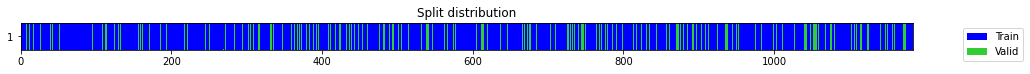

In [ ]:
splits = get_splits(y, valid_size = .2, stratify = True, random_state = 42, shuffle = True)

In [ ]:
class_map = {
    1: 'AD',
    2: 'FTD',
    3: 'HC',
    4: 'MCI'
}

labeler = ReLabeler(class_map)
y = labeler(y)

In [ ]:
X.shape, y.shape, splits

((1185, 200, 140),
 (1185,),
 ((#948) [103,232,700,1152,981,838,405,980,141,236...],
  (#237) [322,872,814,79,1042,553,1049,937,950,201...]))

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms = tfms, splits = splits, inplace = True)
dsets

(#1185) [(TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1))] ...]

# EDA

## Class distribution

In [ ]:
def diplay_align():
  display(HTML("""
  <style>
  #output-body {
      display: flex;
      align-items: center;
      justify-content: center;
  }
  </style>
  """))

Counts by label: {'FTD': 352, 'HC': 361, 'AD': 155, 'MCI': 317}
Naive Accuracy: 30.46%


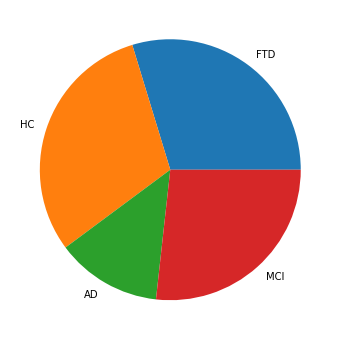

In [ ]:
label_counts = collections.Counter(y)

print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%') # Accuracy if model always predicts the most frequent label

diplay_align()

plt.figure(figsize = (6, 6))
plt.pie(label_counts.values(), labels = label_counts.keys());

## Visualize different classes

In [ ]:
y_ad, y_ftd, y_hc, y_mci = y == 'AD', y == 'FTD', y == 'HC', y == 'MCI'
X_ad, X_ftd, X_hc, X_mci = X[y_ad], X[y_ftd], X[y_hc], X[y_mci]
ad_idx, ftd_idx, hc_idx, mci_idx = np.where(y_ad)[0], np.where(y_ftd)[0], np.where(y_hc)[0], np.where(y_mci)[0]

In [ ]:
def visualize_samples(disease_class, min_range, max_range, num_rows = 3, num_cols = 3):
  if disease_class == 'AD':
    samples = X_ad
    idxs = ad_idx
  elif disease_class == 'FTD':
    samples = X_ftd
    idxs = ftd_idx
  elif disease_class == 'HC':
    samples = X_hc
    idxs = hc_idx
  elif disease_class == 'MCI':
    samples = X_mci
    idxs = mci_idx

  samples = samples[min_range:max_range]
  idxs = idxs[min_range:max_range]

  fig, axs = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, num_rows * 4))
  fig.tight_layout(h_pad = 4)
  fig.suptitle(f"{disease_class} patients", fontsize=18, y = 0.95)
  plt.subplots_adjust(top = 0.9)

  for i, ax in enumerate(axs.ravel()):
    sample = samples[i]
    idx = idxs[i]
    for row_id in range(len(sample)):
      ax.plot(range(140), sample[row_id])
    ax.set_ylim(-20, 20)
    ax.set_title(f"sample: {idx}")
  plt.show()

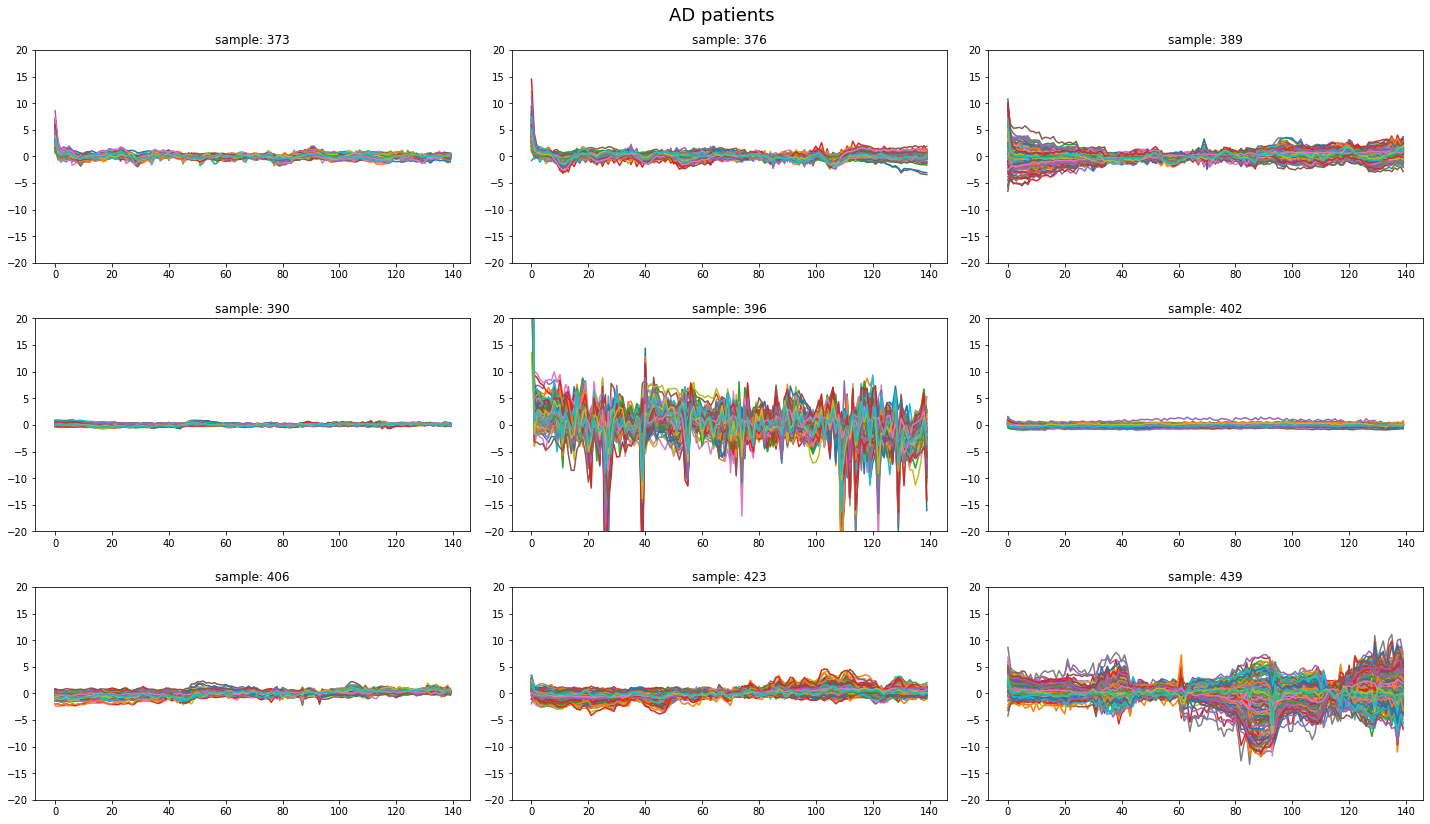

In [ ]:
visualize_samples('AD', min_range = 50, max_range = 59, num_rows = 3, num_cols = 3)

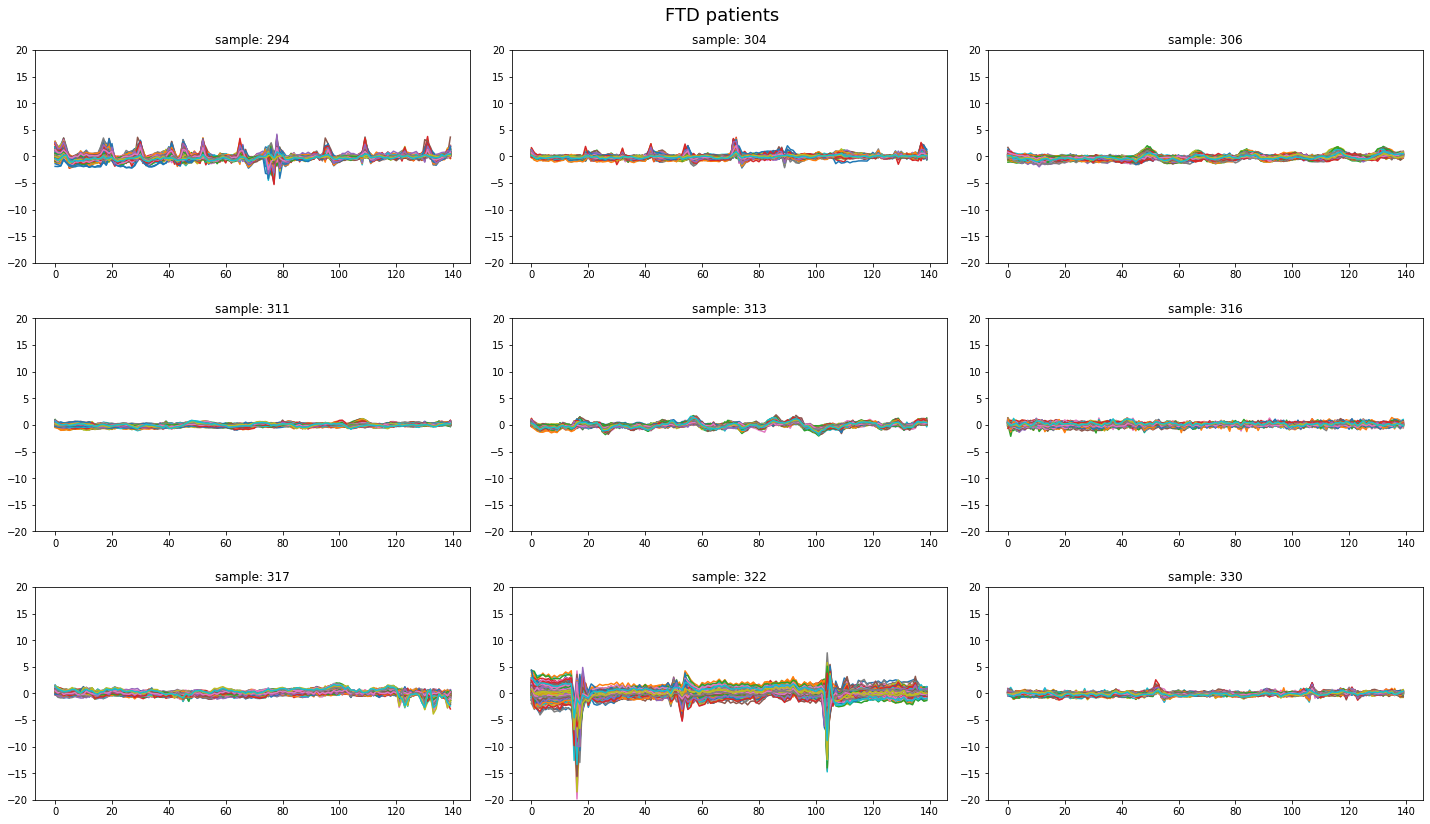

In [ ]:
n = 9
visualize_samples('FTD', min_range = n * 10, max_range = (n + 1) * 10 - 1, num_rows = 3, num_cols = 3)

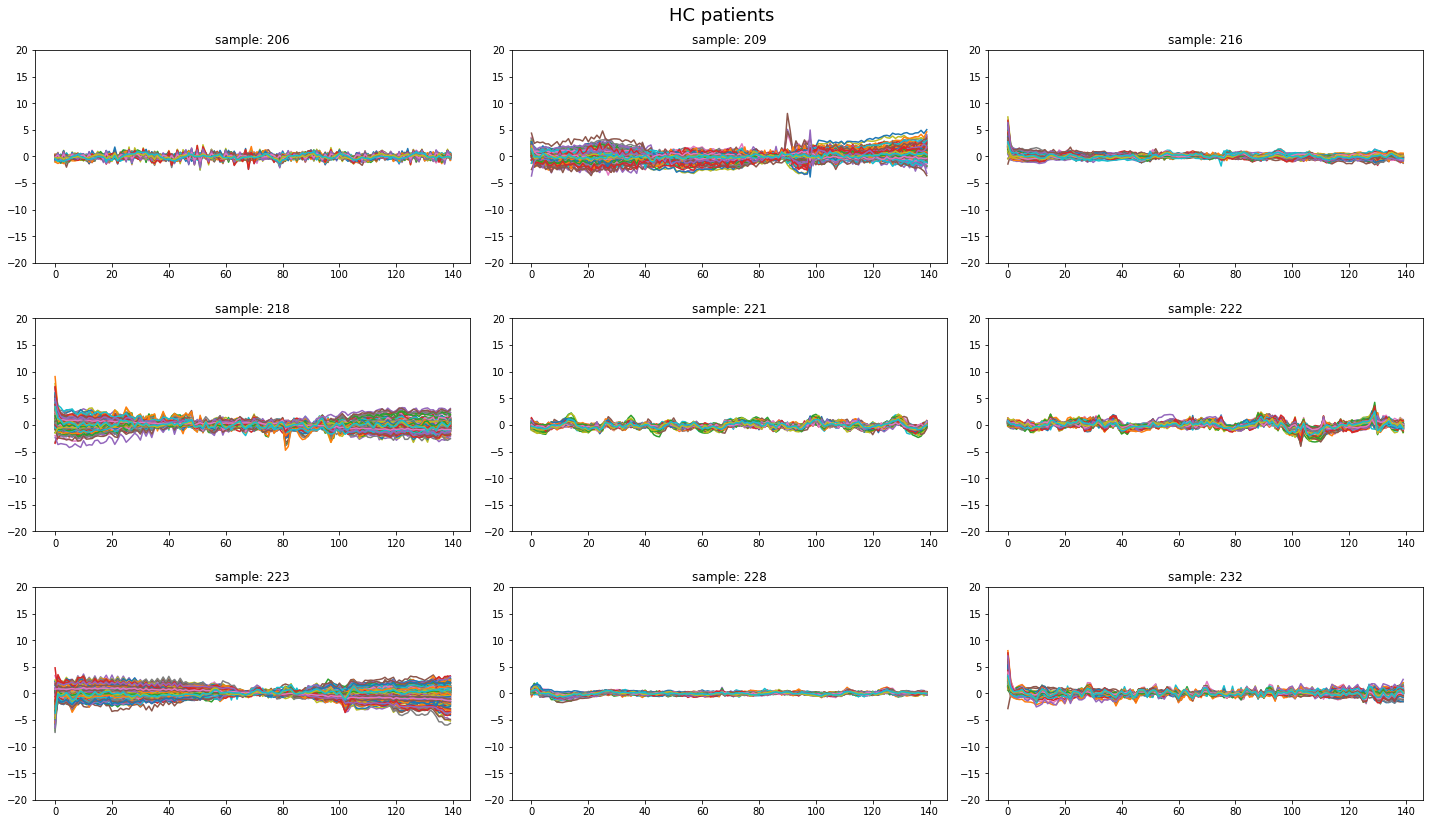

In [ ]:
n = 7
visualize_samples('HC', min_range = n * 10, max_range = (n + 1) * 10 - 1, num_rows = 3, num_cols = 3)

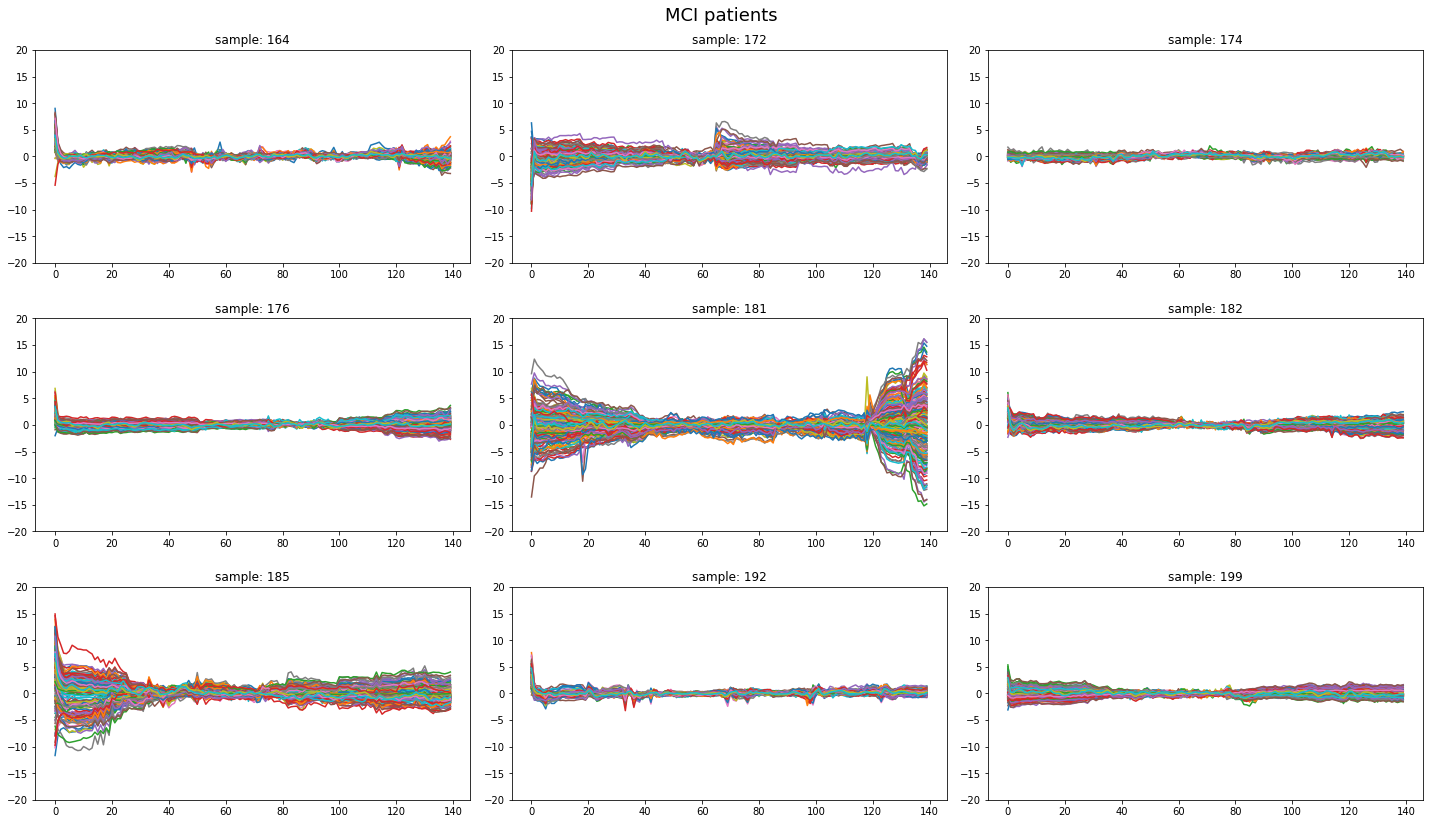

In [ ]:
n = 4
visualize_samples('MCI', min_range = n * 10, max_range = (n + 1) * 10 - 1, num_rows = 3, num_cols = 3)

In [ ]:
def visualize_select_samples(idx, num_rows, num_cols, plot_title):

  fig, axs = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, num_rows * 4))
  fig.tight_layout(h_pad = 4)
  fig.suptitle(plot_title, fontsize=18, y = 0.95)
  plt.subplots_adjust(top = 0.9)

  for idx, ax in zip(idx, axs.ravel()):
    sample = X[idx]
    for row_id in range(len(sample)):
      ax.plot(range(140), sample[row_id])
    ax.set_ylim(-20, 20)
    ax.set_title(f"sample: {idx}")
  plt.show()

In [ ]:
ad_wave = [14, 28, 53, 65, 149, 169, 179, 250, 275, 324, 396, 439]
ad_no_wave = [22, 117, 118, 188, 220, 247, 351, 390, 402]

ftd_wave = [16, 23, 81, 147, 158, 177, 201, 254, 273, 282, 294, 313]
ftd_no_wave = [8, 13, 84, 89, 144, 160, 208, 210, 238]

hc_wave = [6, 11, 17, 29, 49, 51, 85, 111, 123, 137, 142, 221]
hc_no_wave = [3, 10, 35, 55, 62, 92, 112, 125, 228]

mci_wave = [7, 48, 88, 91, 98, 104, 128, 134, 155, 156, 172, 181]
mci_no_wave = [68, 73, 93, 107, 140, 161, 174, 176, 182]

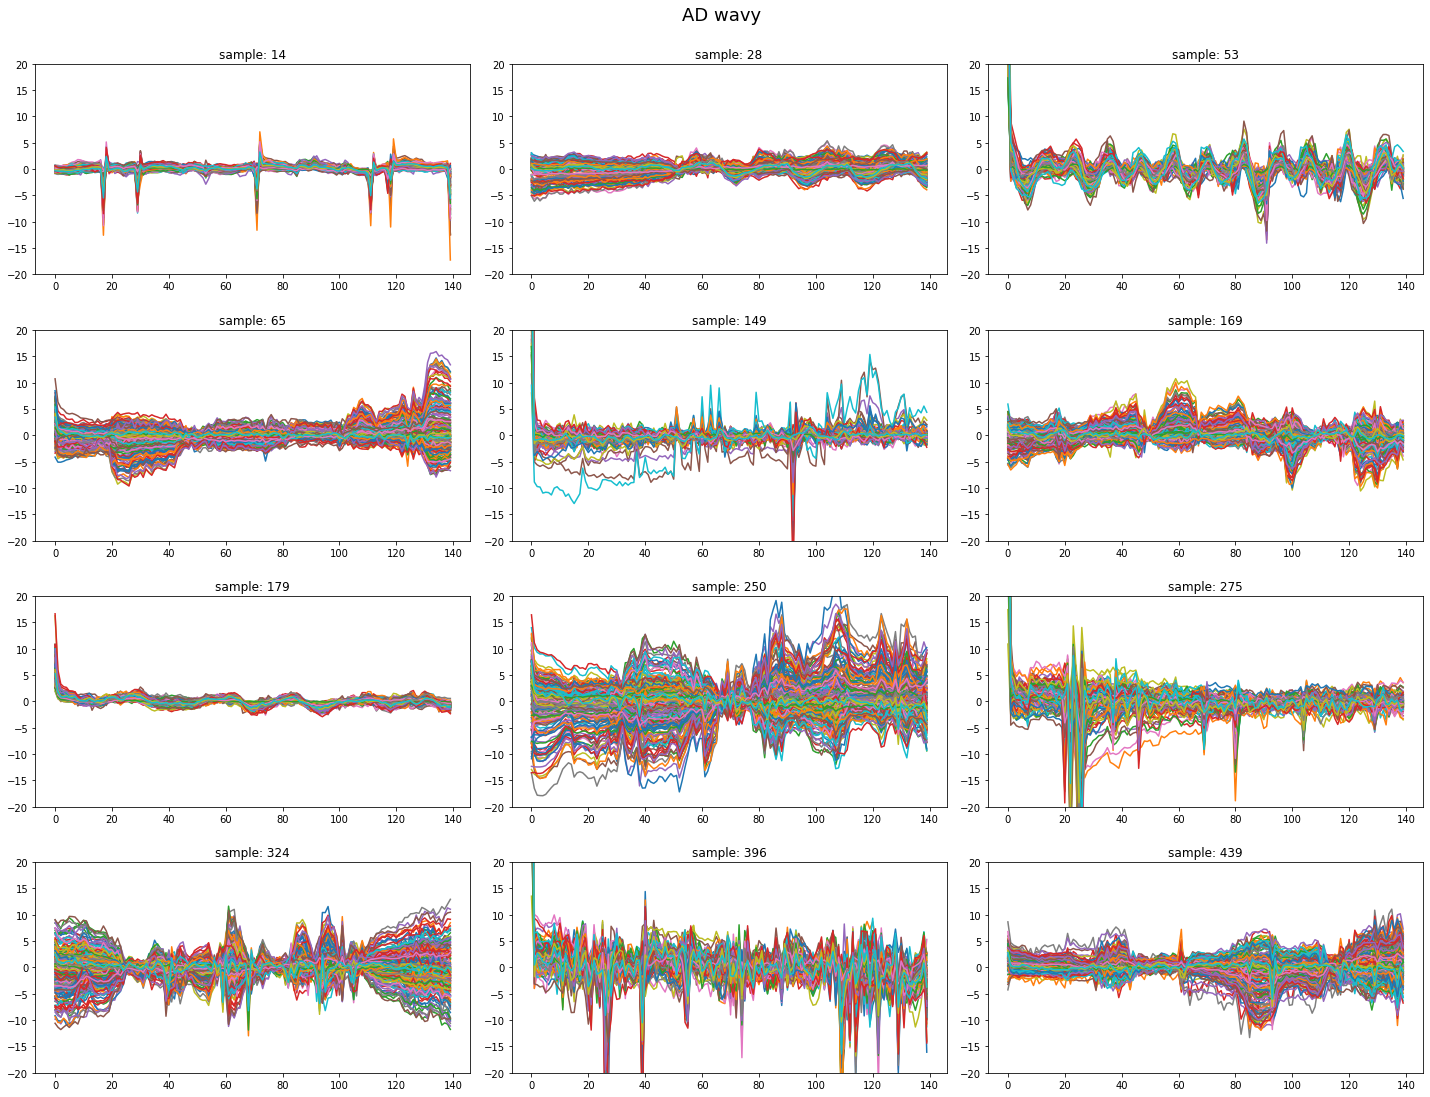

In [ ]:
visualize_select_samples(ad_wave, 4, 3, 'AD wavy')

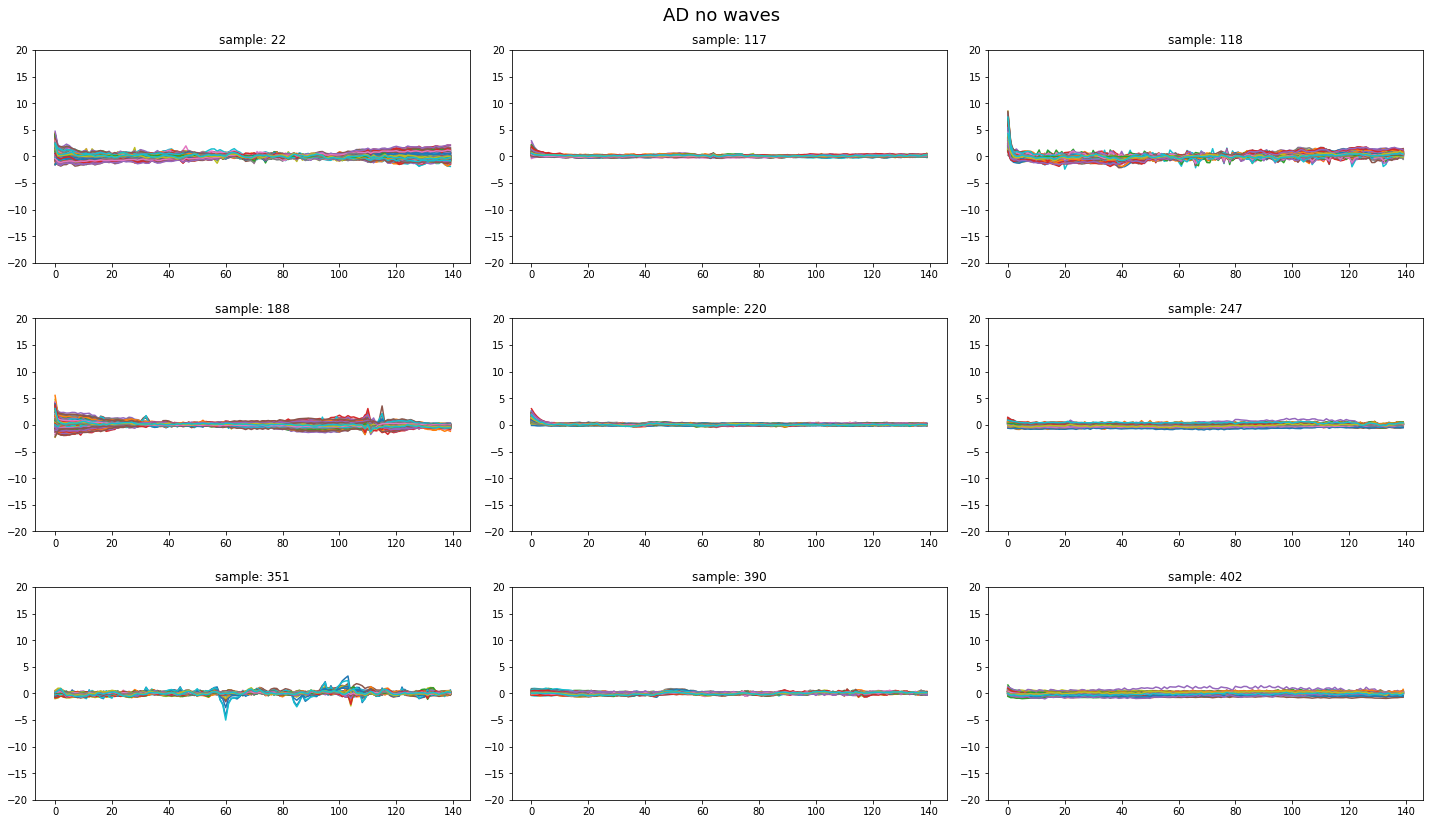

In [ ]:
visualize_select_samples(ad_no_wave, 3, 3, 'AD no waves')

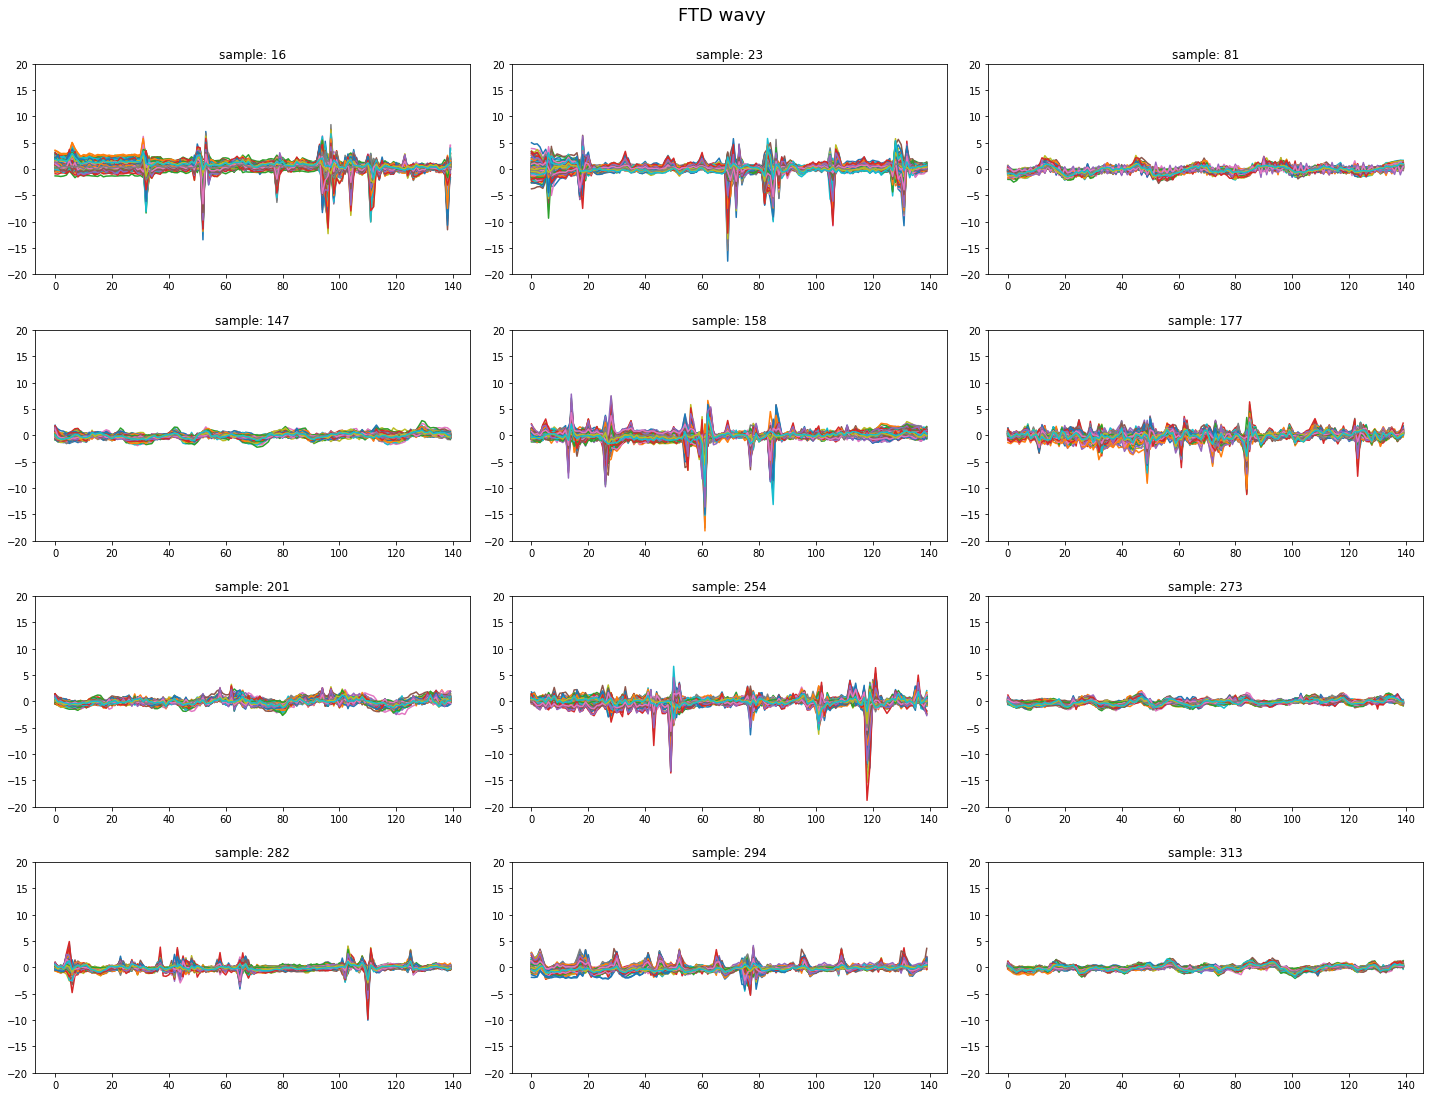

In [ ]:
visualize_select_samples(ftd_wave, 4, 3, 'FTD wavy')

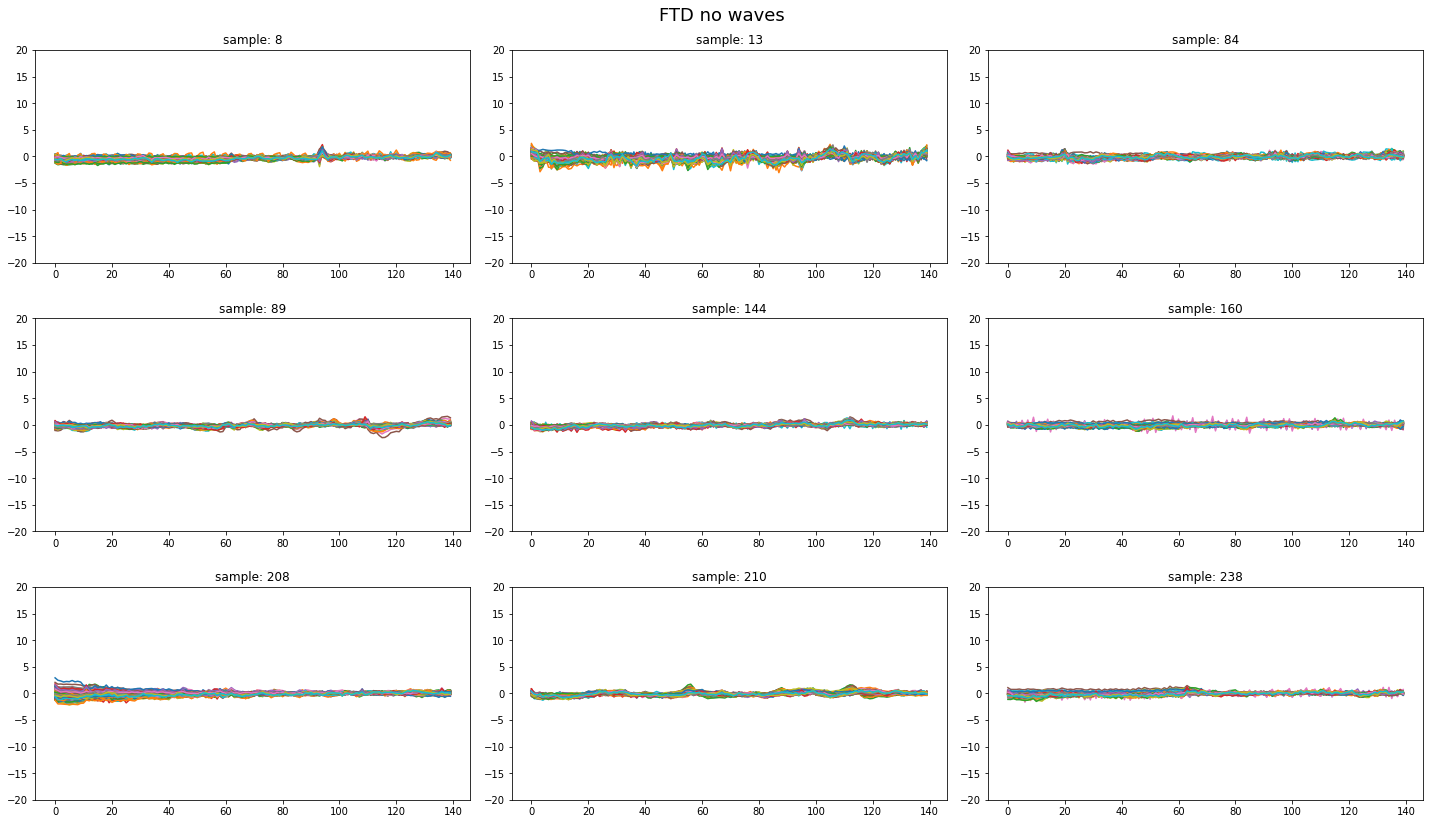

In [ ]:
visualize_select_samples(ftd_no_wave, 3, 3, 'FTD no waves')

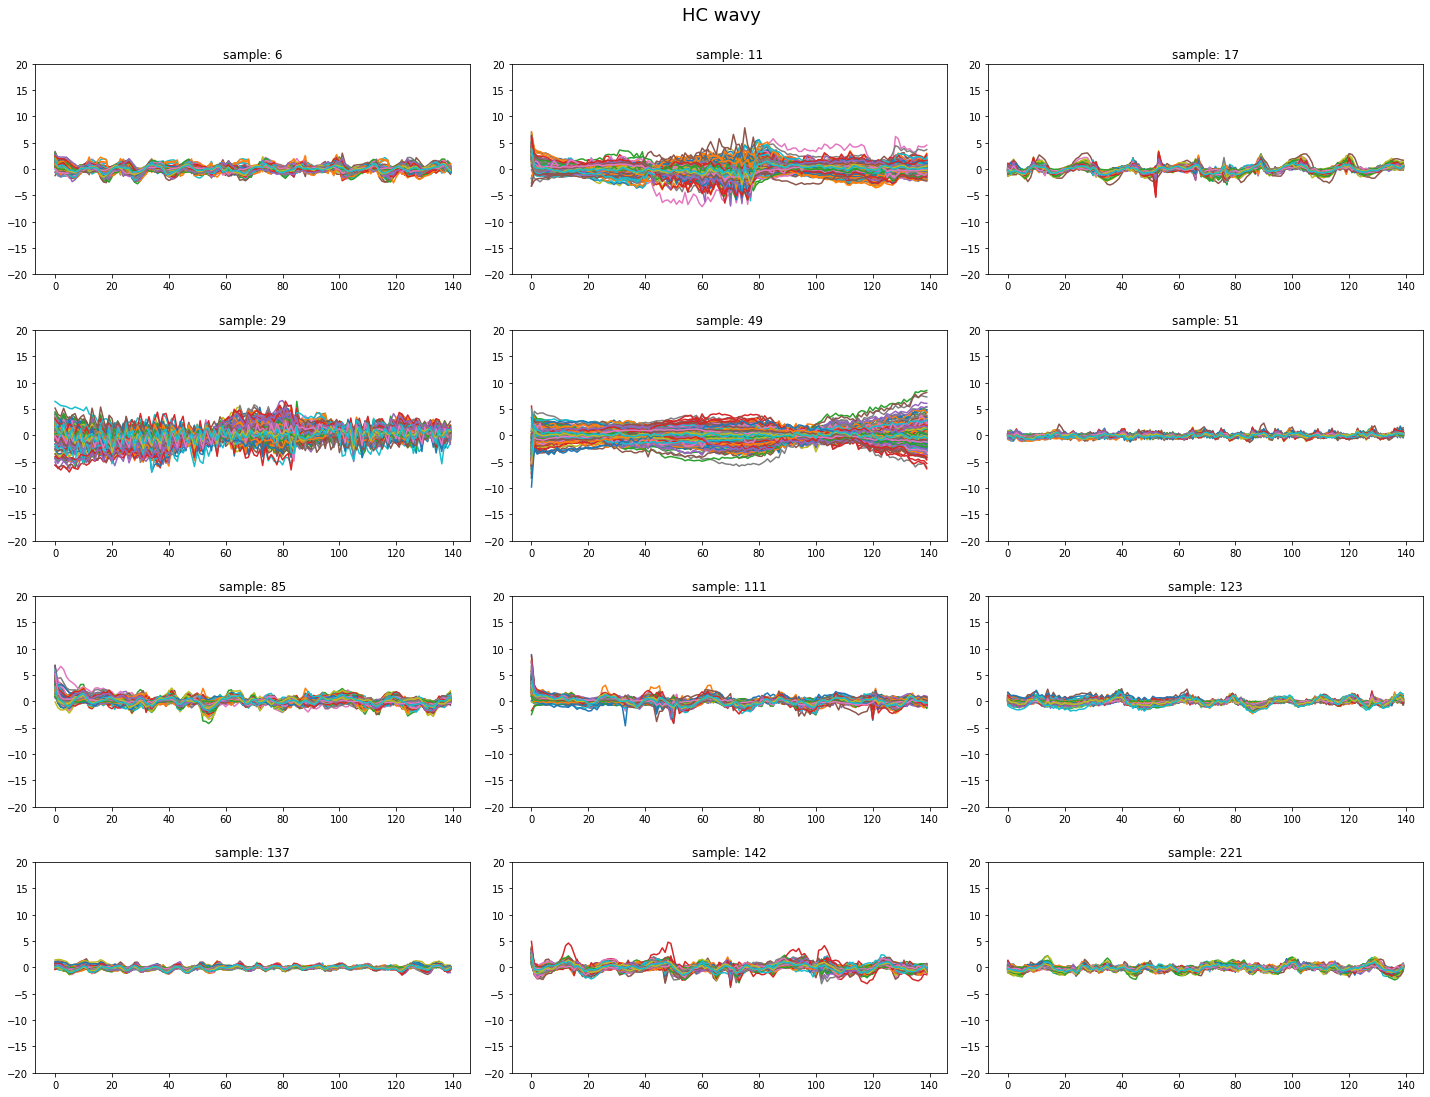

In [ ]:
visualize_select_samples(hc_wave, 4, 3, 'HC wavy')

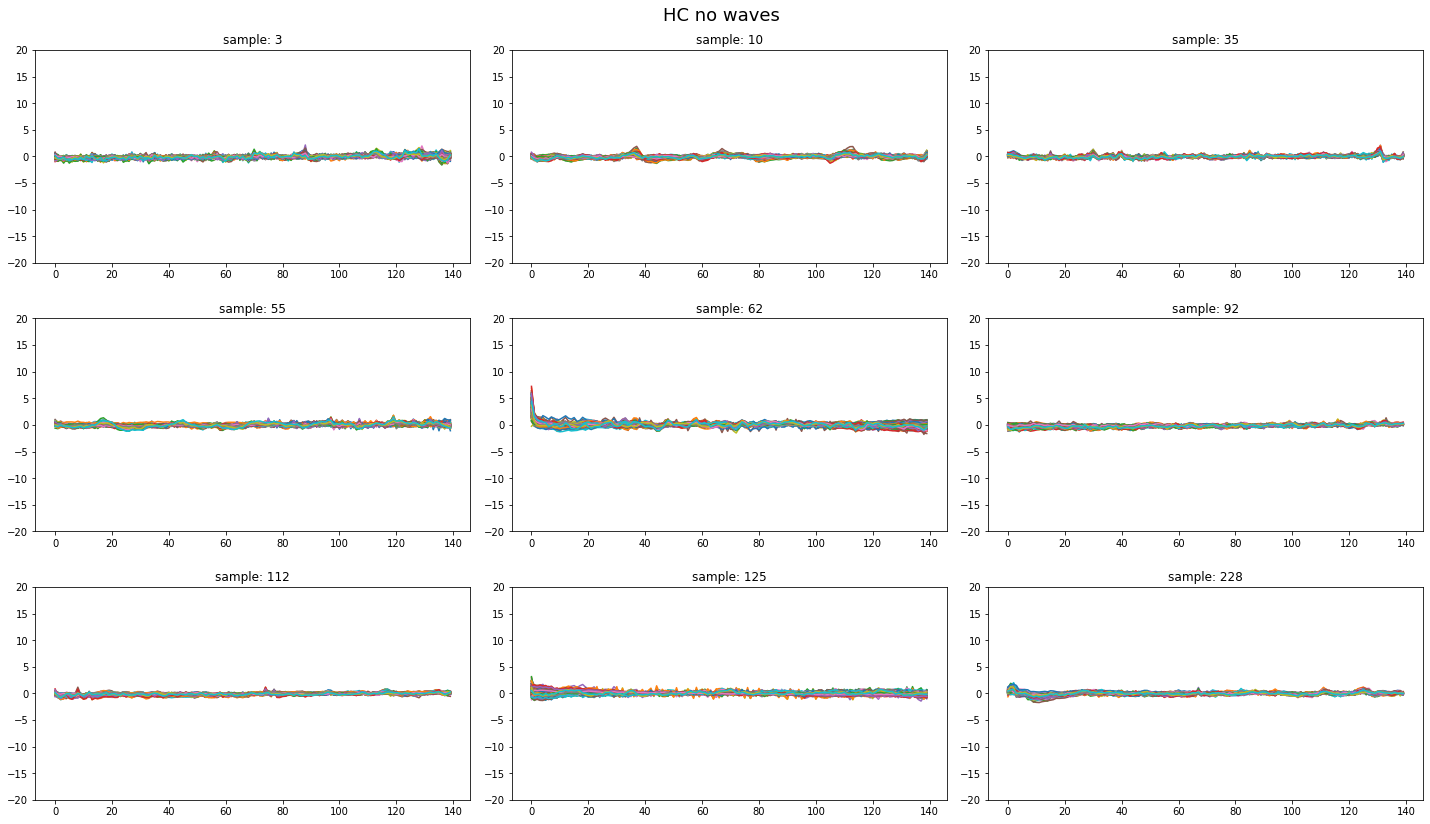

In [ ]:
visualize_select_samples(hc_no_wave, 3, 3, 'HC no waves')

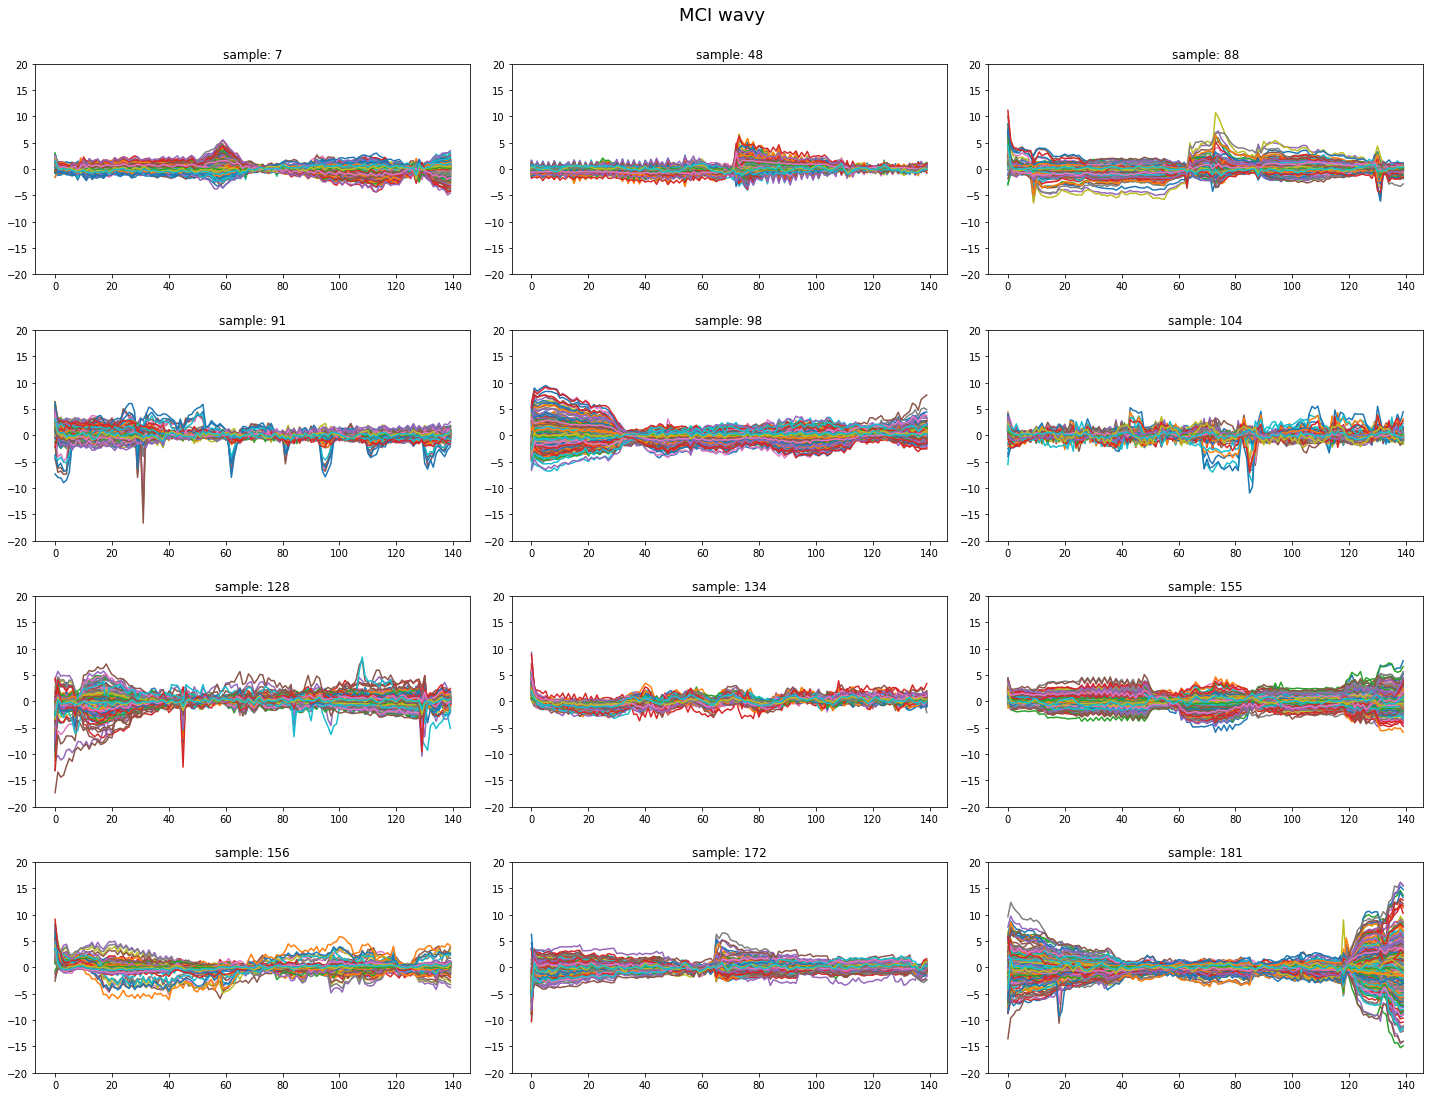

In [ ]:
visualize_select_samples(mci_wave, 4, 3, 'MCI wavy')

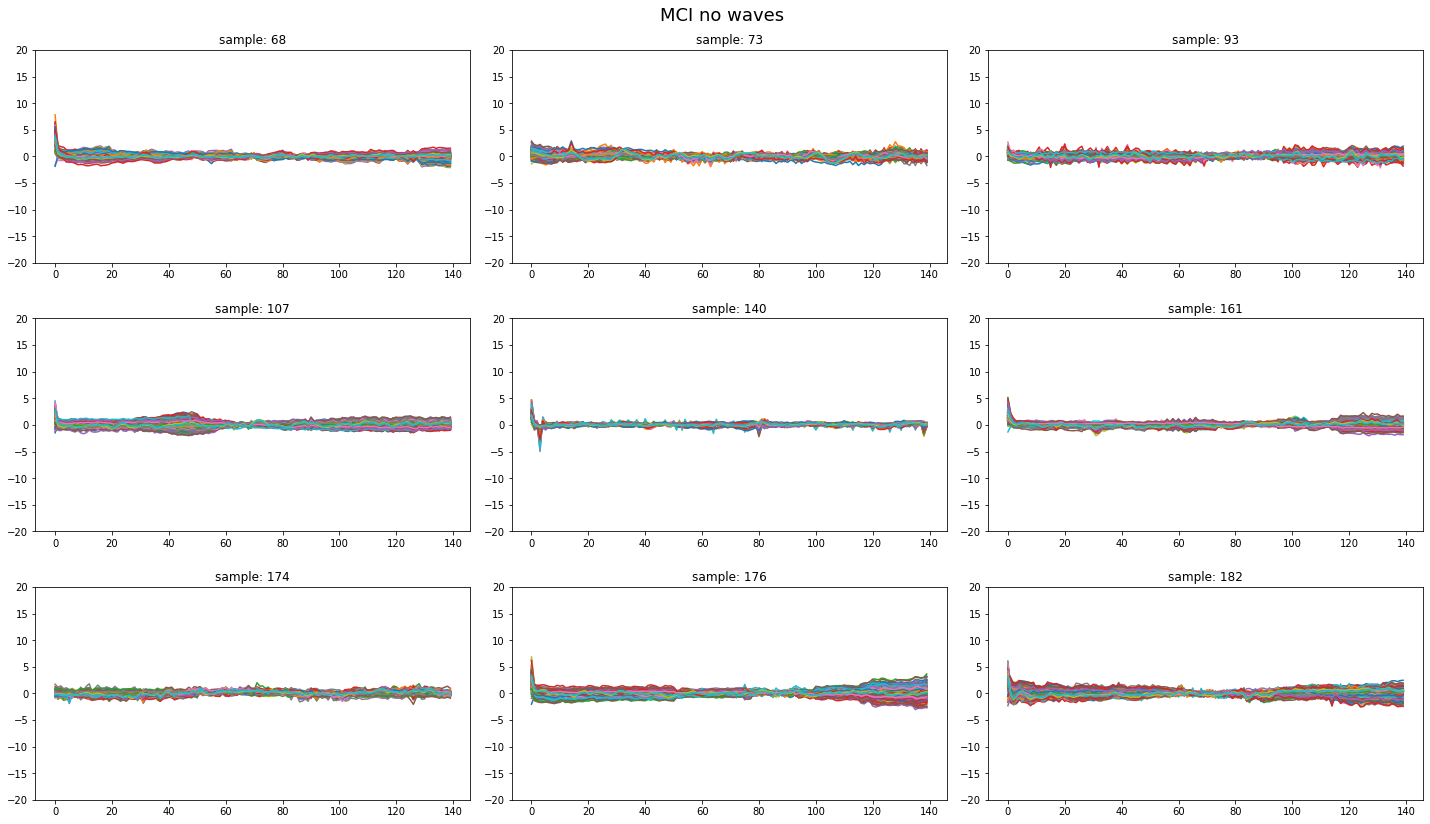

In [ ]:
visualize_select_samples(mci_no_wave, 3, 3, 'MCI no waves')

# Create dataloaders

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs = [64, 128],
                              #  batch_tfms = [TSStandardize()],
                               num_workers=0)

In [ ]:
dls.dataset

(#948) [(TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:200, len:140, device=cpu, dtype=torch.float32), TensorCategory(2))] ...]

## Visualize data

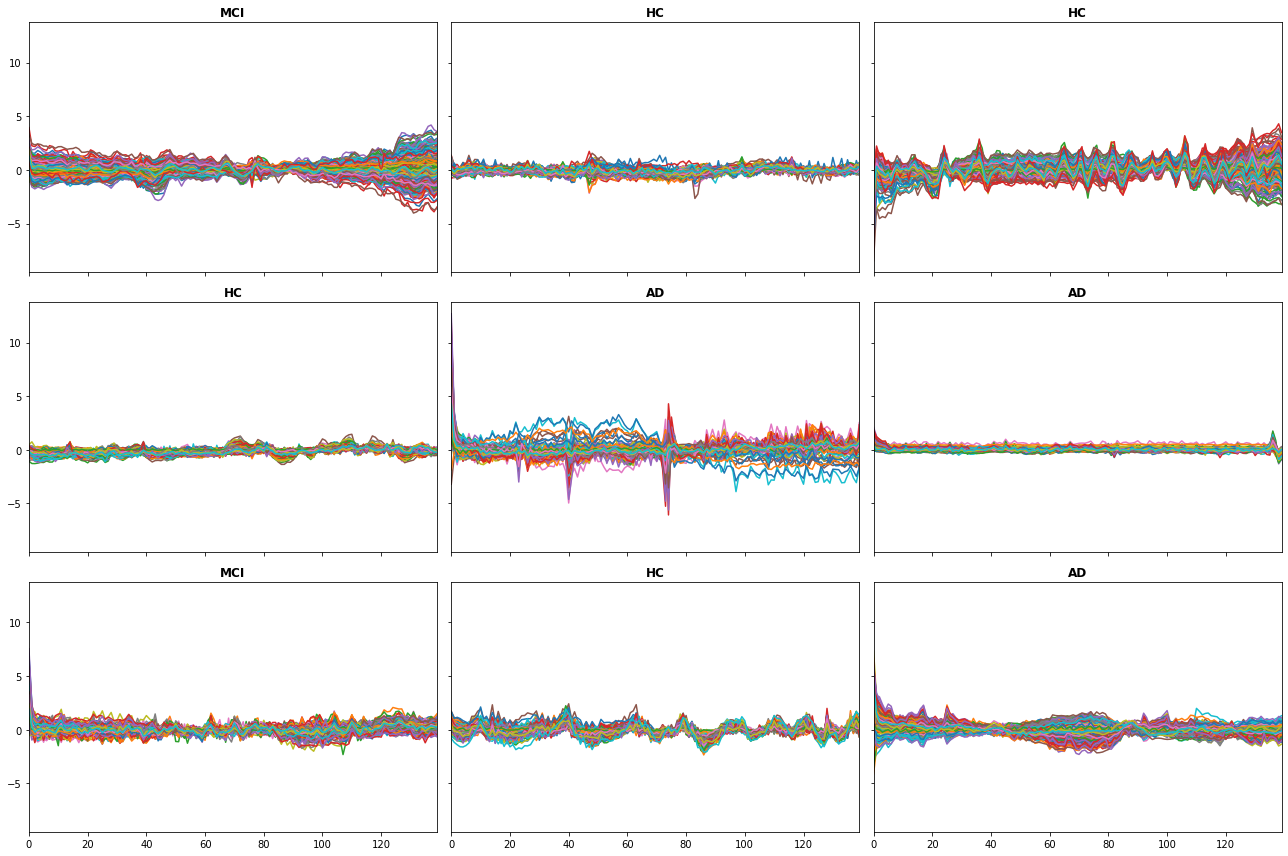

In [ ]:
dls.show_batch(sharey=True)

# Build and train models

## Custom multiclassification metrics

In [ ]:
def balanced_accuracy(input, target):
  input, target = input.cpu(), target.cpu()
  input, target = flatten_check(input.argmax(axis = -1), target)
  output = balanced_accuracy_score(target, input)
  return output

def balanced_f1(input, target):
  input, target = input.cpu(), target.cpu()
  input, target = flatten_check(input.argmax(axis = -1), target)
  output = f1_score(target, input, average = 'weighted')
  return output

## LSTM-FCN model

### Create model

In [ ]:
model = LSTM_FCN(dls.vars, dls.c, seq_len = 140)
learn = Learner(dls, model, metrics = [accuracy, balanced_accuracy, balanced_f1])
learn.save('stage0')

Path('models/stage0.pth')

### Train model

#### LR find

SuggestedLRs(valley=0.0008317637839354575)

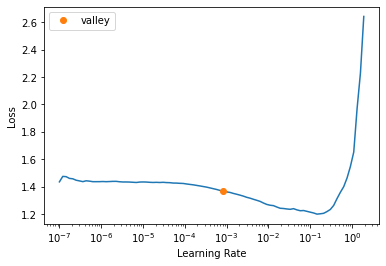

In [ ]:
learn.load('stage0')
learn.lr_find()

#### Train

In [ ]:
learn.fit_one_cycle(30, lr_max = 1e-3)
learn.save('stage1')

Path('models/stage1.pth')

#### Visualize training

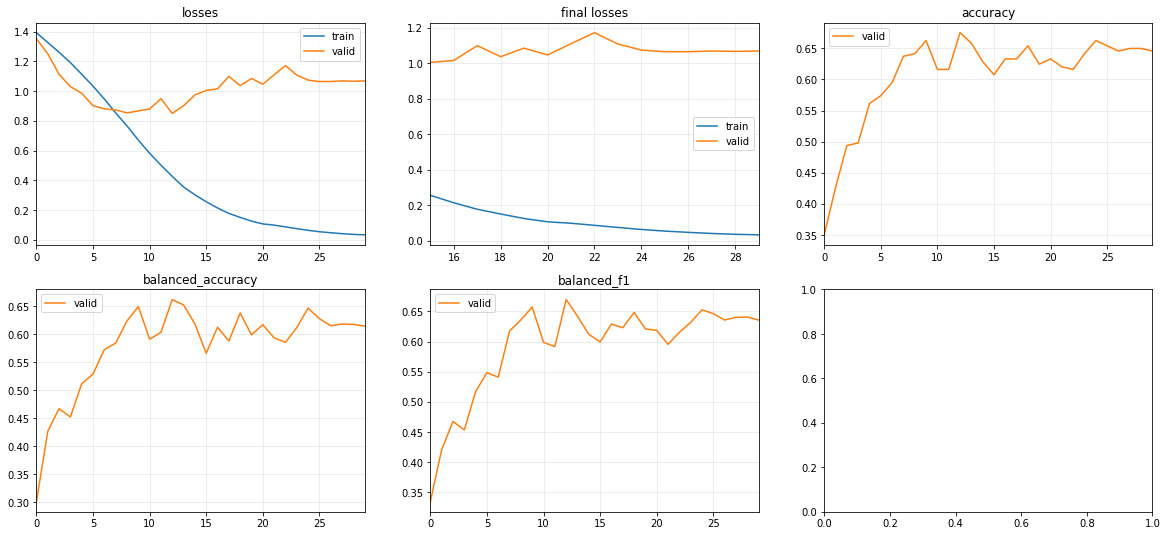

In [ ]:
learn.recorder.plot_metrics()

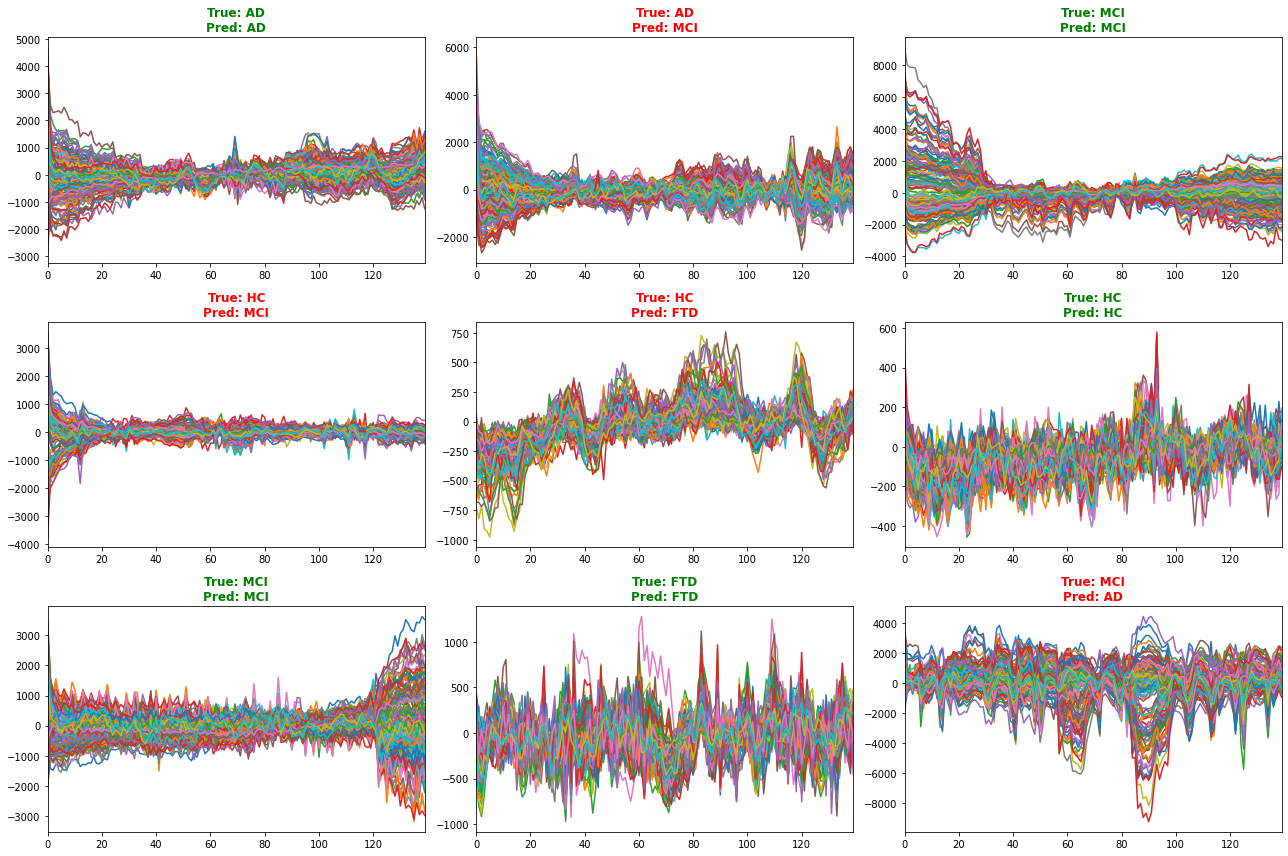

In [ ]:
learn.show_results()

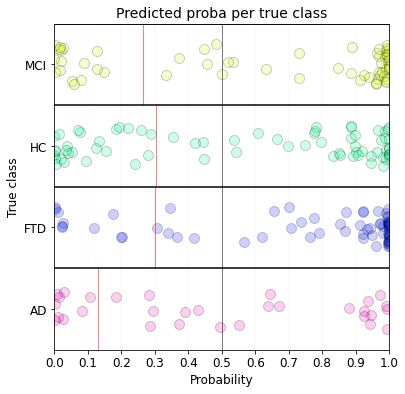

In [ ]:
learn.show_probas()

### Interpreting misclassifications

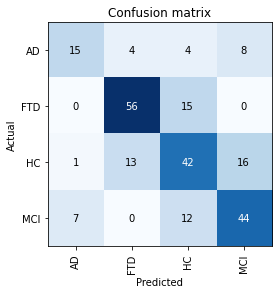

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=3)

[('HC', 'MCI', 16),
 ('FTD', 'HC', 15),
 ('HC', 'FTD', 13),
 ('MCI', 'HC', 12),
 ('AD', 'MCI', 8),
 ('MCI', 'AD', 7),
 ('AD', 'FTD', 4),
 ('AD', 'HC', 4)]

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl = dls.valid, with_decoded = True)

In [ ]:
pred_probas = np.amax(valid_probas.cpu().numpy(), axis = 1)

In [ ]:
true_list = valid_targets != valid_preds

misclassified_samples = splits[1][true_list]
misclassified_probas = pred_probas[true_list]
misclassified_targets = valid_targets[true_list]
misclassified_preds = valid_preds[true_list]

In [ ]:
c_info = {
    'sample': misclassified_samples,
    'probas': misclassified_probas,
    'targets': misclassified_targets,
    'preds': misclassified_preds
}

misclassified = pd.DataFrame(c_info)

misclassified = misclassified.replace({
    'targets': {0: 'AD',
                1: 'FTD',
                2: 'HC',
                3: 'MCI'},
     'preds': {0: 'AD',
               1: 'FTD',
               2: 'HC',
               3: 'MCI'}
})

mc_sorted_probas = misclassified.sort_values('probas', ascending = False).reset_index(drop = True)

mc_sorted_probas[:10]

sample    probas targets preds
0     769  1.000000      HC   FTD
1     480  0.999997     MCI    HC
2     741  0.999330     FTD    HC
3     148  0.999087     MCI    HC
4     615  0.999043      HC   MCI
5    1020  0.998711      HC   FTD
6     162  0.997981     MCI    HC
7     380  0.997795     FTD    HC
8    1052  0.997043      HC   MCI
9     246  0.992954      HC   MCI

In [ ]:
worst_pred_samples = mc_sorted_probas['sample'].values
worst_pred_preds = mc_sorted_probas['preds'].values
worst_pred_targs = mc_sorted_probas['targets'].values

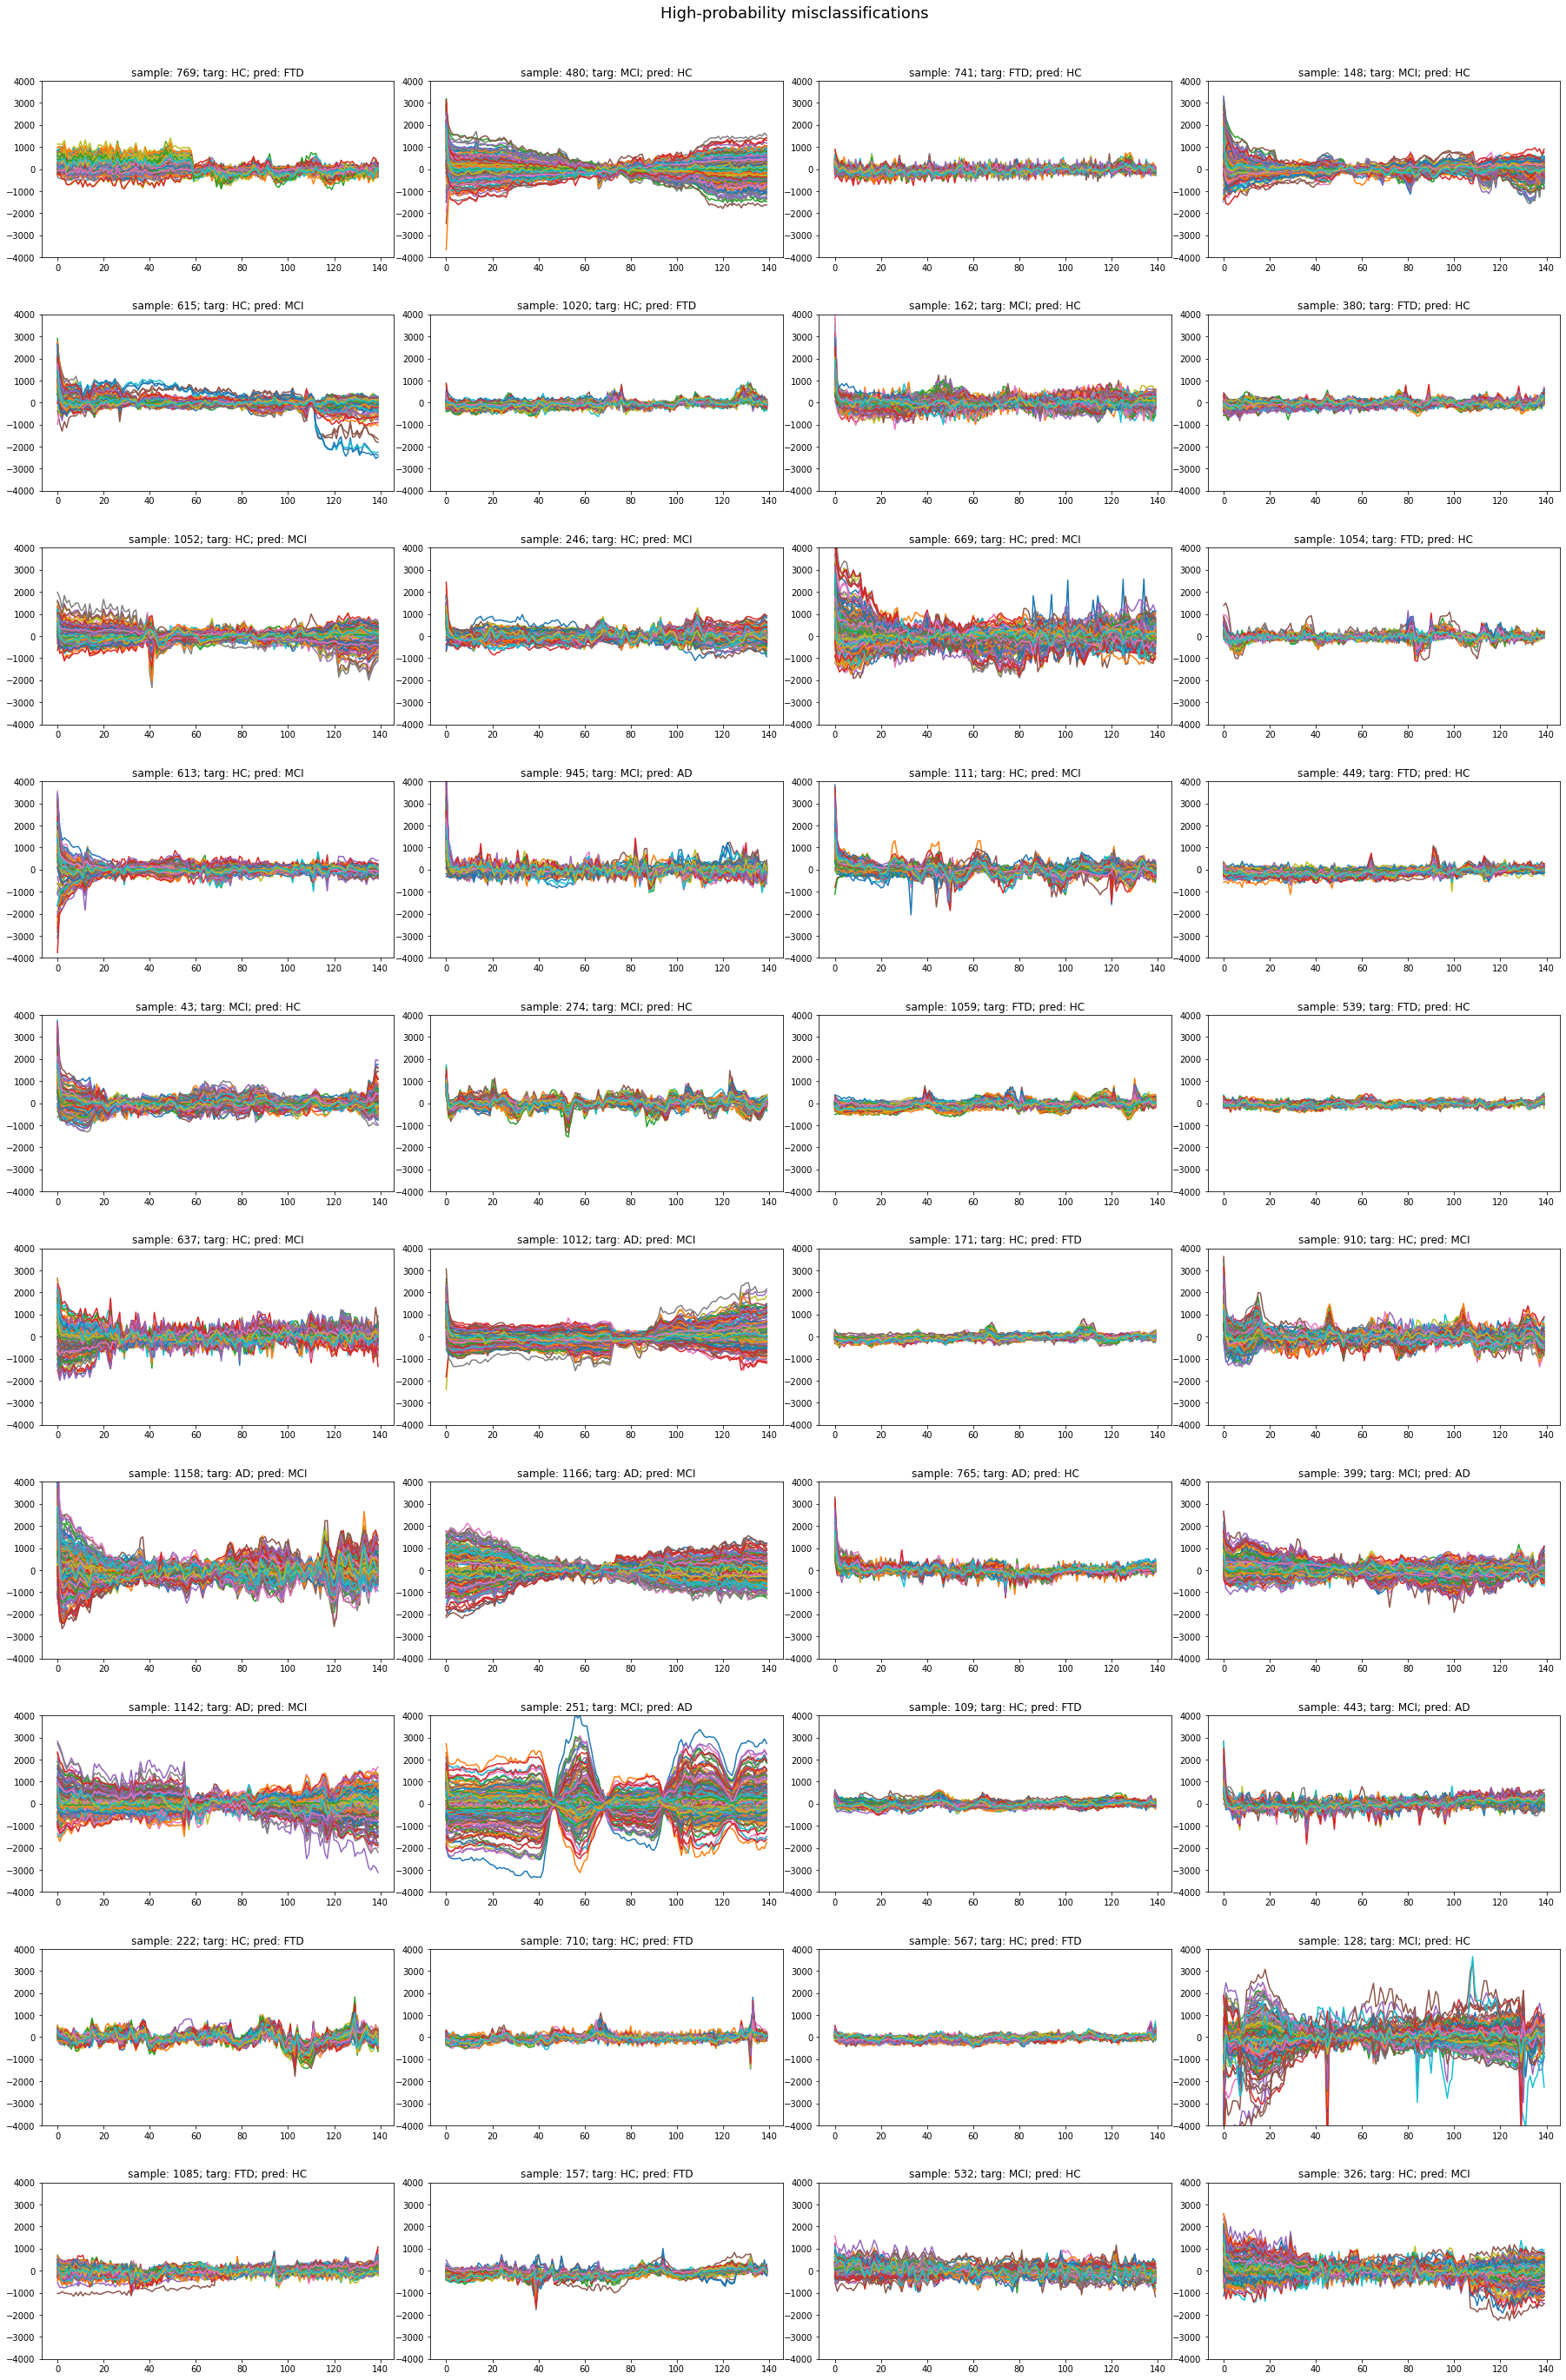

In [ ]:
n = 10

fig, axs = plt.subplots(nrows = n, ncols = 4, figsize = (25, n * 4))
fig.tight_layout(h_pad = 5)
fig.suptitle("High-probability misclassifications", fontsize=18, y = 0.95)
plt.subplots_adjust(top = 0.92)

for idx, pred, targ, ax in zip(worst_pred_samples, worst_pred_preds, worst_pred_targs, axs.ravel()):
  sample = X[idx]
  for row_id in range(len(sample)):
    ax.plot(range(140), sample[row_id])
  ax.set_ylim(-4000, 4000)
  ax.set_title(f"sample: {idx}; targ: {targ}; pred: {pred}")
plt.show()

# Transformer-based model

In [ ]:
c_in = dls.vars
c_out = dls.c
seq_len = dls.len
max_seq_len = None
d_model = 256 # Usual values: 128 - 1024; Number of features created by the model
n_heads = 16 # Usual values: 8 - 16; Parallel attention heads
d_k = None # Usual values: 16 - 512; Size of the learned linear projection of queries and keys inthe MHA
d_v = None # Usual values: 16 - 512; Size of the learned linear projection of values in the MHA
d_ff = 512 # Usual values: 256 - 4096; Size of the feedforward network model
dropout = 0.1 # Usual values: 0 - 0.3; Amount of residual dropout applied in the encoder
# activation = 'gelu' # gelu or relu
n_layers = 3 # Usual values: 2 - 8; Number of sub-encoder layers
fc_dropout = 0 # Usual values: 0 - 0.8; Dropout applied to the final fully connected layer

In [ ]:
model_tst = TST(c_in, c_out, seq_len, max_seq_len = max_seq_len, d_model = d_model,
            n_heads = n_heads, d_k = d_k, d_v = d_v, d_ff = d_ff, dropout = dropout,
            n_layers = n_layers, fc_dropout = fc_dropout)


In [ ]:
learn_tst = Learner(dls, model_tst, metrics = [accuracy, balanced_accuracy, balanced_f1])
learn_tst.save('stage0')

Path('models/stage0.pth')

SuggestedLRs(valley=0.00013182566908653826)

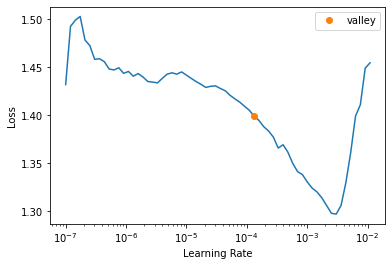

In [ ]:
learn_tst.load('stage0')
learn_tst.lr_find()

In [ ]:
learn_tst.fit_one_cycle(30, lr_max = 1e-3)
learn_tst.save('stage1')

Path('models/stage1.pth')